# Grouped and Dummy Regression

## 그룹화된 데이터를 사용한 회귀


모든 데이터가 동일하게 생성되는 것은 아니다.

ENEM 데이터 세트를 다시 보면, 작은 규모의 학교 점수보다 큰 규모의 학교 점수를 훨씬 더 신뢰한다.

이것은 큰 규모의 학교, 즉 크기가 클수록 분산이 작기 때문이다.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import style
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf

style.use("fivethirtyeight")

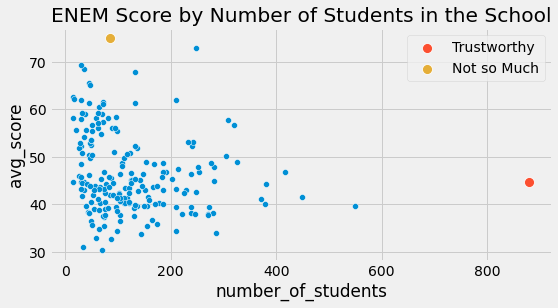

In [2]:
np.random.seed(876)
enem = pd.read_csv("./data/enem_scores.csv").sample(200)
plt.figure(figsize=(8,4))
sns.scatterplot(y="avg_score", x="number_of_students", data=enem)
sns.scatterplot(y="avg_score", x="number_of_students", s=100, label="Trustworthy",
                data=enem.query(f"number_of_students=={enem.number_of_students.max()}"))
sns.scatterplot(y="avg_score", x="number_of_students", s=100, label="Not so Much",
                data=enem.query(f"avg_score=={enem.avg_score.max()}"))
plt.title("ENEM Score by Number of Students in the School");

직관적으로 봤을 때, 왼쪽 점이 오른쪽 점보다 모형에 미치는 영향이 적어야 한다.

기본적으로 오른쪽 점은 실제 단일 항목으로 그룹화된 많은 여러 데이터들의 점이다. 

우리가 그것들을 그룹으로 묶지 않고, 선형 회귀 분석을 실행할 수 있다면, 실제로 왼쪽의 묶이지 않은 점보다 오른쪽 점이 모델 추정에 훨씬 더 많은 기여를 할 것이다.

분산이 낮은 영역과 분산이 높은 영역을 동시에 갖는 이러한 현상을 ***이분산성*** 이라고 한다.

간단히 말해서 이분산성은 변수의 모든 값에서 분산이 일정하지 않은 경우이다.

위의 경우, 변수 샘플 크기가 증가함에 따라 분산이 감소하는 것을 볼 수 있다.

이분산성이 있는 또 다른 예로는, 임금을 연령별로 도표화하면 젊은 사람보다 노인의 임금 편차가 더 크다는 것을 알 수 있다. 그러나 분산이 달라지는 가장 일반적인 이유는 그룹화된 데이터 때문이다.

위와 같이 그룹화된 데이터는 데이터 분석에서 매우 일반적. 그것에 대한 이유는 기밀성이다. 데이터 개인 정보보호 요구 사항에 의해 개인 데이터를 제공할 수 없다.
따라서, 데이터를 그룹화하는 방법으로만 반출이 가능하다. 이러한 방식으로 인해, 개인은 그룹화되어 더 이상 고유하게 식별할 수 없다.

다행히도, 회귀는 이러한 종류의 데이터를 꽤 잘 처리할 수 있다.

그 방법을 이해하기 위해, 먼저 임금 및 교육에 대한 데이터와 같은 그룹화되지 않은 데이터를 살펴보자.


아래 데이터에서는 각 개인에 대한 임금과 교육 기간 정보를 확인할 수 있다.

In [3]:
wage = pd.read_csv("./data/wage.csv")[['wage', 'lhwage', 'educ','IQ']]

wage.head()

,wage,lhwage,educ,IQ
0,769,2.956212,12,93
1,808,2.782539,18,119
2,825,3.026504,14,108
3,650,2.788093,12,96
4,562,2.642622,11,74


교육이 로그 시간당 임금과 어떤 연관이 있는지 알아보기 위해 회귀 모델을 실행해보자.

In [4]:
model_1 = smf.ols('lhwage ~ educ', data=wage).fit()
model_1.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2.2954,0.089,25.754,0.000,2.121,2.470
educ,0.0529,0.007,8.107,0.000,0.040,0.066


이 데이터가 기밀성에 대한 제약을 받고 있다고 가정해보자.

제공자는 개별화된 데이터를 제공할 수가 없다. 그래서 우리는 교육을 받은 모든 사람을 그룹화하고 평균 로그 시간당 임금과 각 그룹의 개인 수만 받을 수 있다면, 아래와 같이 
10개의 데이터 포인트만 남게 된다.

In [7]:
group_wage = (wage.assign(count=1)
             .groupby("educ")
              .agg({"lhwage":"mean", "count":"count"})
              .reset_index())


In [8]:
group_wage

,educ,lhwage,count
0,9,2.856475,10
1,10,2.786911,35
2,11,2.855997,43
3,12,2.922168,393
4,13,3.021182,85
5,14,3.042352,77
6,15,3.090766,45
7,16,3.176184,150
8,17,3.246566,40
9,18,3.144257,57


선형회귀모델에 가중치를 제공할 수 있다.
가중 최소 제곱에 대해 `smf.ols`를 `smf.wls`로 대체한다.

In [9]:
model_2 = smf.wls('lhwage ~ educ', data=group_wage, weights=group_wage["count"]).fit()
model_2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2.2954,0.078,29.327,0.000,2.115,2.476
educ,0.0529,0.006,9.231,0.000,0.040,0.066


model_1과 model_2를 비교해보자.

그룹화된 모델 model_2에서 educ의 모수 추정치가 그룹화되지 않은 데이터의 모수 추정치에 얼마나 가까운지 확인할 수 있다.(이 경우에는 동일)

데이터 포인트가 10개밖에 없어도 통계적으로 유의미한 계수를 얻을 수 있다.

포인트가 적지만, 그룹화를 통해 분산도 많이 줄어들기 때문이다.

또한 표준편차(std)가 약간 더 크고 t통계량이 약간 더 크다.

분산에 대한 일부 정보가 손실되기 때문에 더 보수적이기 때문이다.

데이터를 그룹화하면 각 그룹 내에서 분산이 얼마나 큰지 알 수 없다.

위의 결과를 가중치가 없는 모델로 얻은 결과와 비교해보자.

In [10]:
model_3 = smf.ols('lhwage ~ educ', data=group_wage).fit()
model_3.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2.3650,0.082,28.988,0.000,2.177,2.553
educ,0.0481,0.006,8.136,0.000,0.034,0.062


model_3의 모수 추정치가 model_2의 모수 추정치보다 더 작다.

이는 회귀분석에서 모든 점에 동일한 가중치를 부여하고 있기 때문이다.

그룹화된 점을 따라 모델을 plotting해보면 가중치가 없는 모델이 왼쪽 하단의 작은 점에 더 많은 중요성을 부여하고 있음을 알 수 있다.

결과적으로 더 낮은 기울기의 line을 가진다.

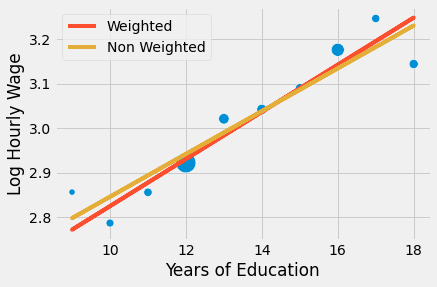

In [11]:
sns.scatterplot(x="educ", y = "lhwage", size="count", legend=False, data=group_wage, sizes=(40, 400))
plt.plot(wage["educ"], model_2.predict(wage["educ"]), c="C1", label = "Weighted")
plt.plot(wage["educ"], model_3.predict(wage["educ"]), c="C2", label = "Non Weighted")
plt.xlabel("Years of Education")
plt.ylabel("Log Hourly Wage")
plt.legend();

가중 회귀 분석을 사용하려면 평균 통계량이 필요하다.

공변량 및 종속 변수 모두에 대해 사용한다.

그룹화 데이터를 사용한 가중 회귀 분석의 결과는 그룹화되지 않은 데이터의 회귀 분석과 정확히 일치하지는 않지만, 꽤 유사하다.

아래는 그룹화된 데이터 모델에서 추가 공변량을 사용하는 예제이다.

In [12]:
group_wage = (wage
              .assign(count=1)
              .groupby("educ")
              .agg({"lhwage":"mean", "IQ":"mean", "count":"count"})
              .reset_index())

model_4 = smf.wls('lhwage ~ educ + IQ', data=group_wage, weights=group_wage["count"]).fit()
print("Number of observations:", model_4.nobs)
model_4.summary().tables[1]

Number of observations: 10.0


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.8821,0.324,5.800,0.001,1.115,2.649
educ,0.0257,0.021,1.198,0.270,-0.025,0.077
IQ,0.0077,0.006,1.309,0.232,-0.006,0.022


교육 기간 이외에도 IQ를 변수로 포함했다.

구조는 거의 동일하다.

평균과 카운트를 구하고, 평균으로 회귀하고 카운트를 가중치로 사용한다.

# Regression for Dummies

더미 변수란 이진 열로 인코딩한 범주형 변수이다.

|gender|female|other|
|------|:-----|:----|
|male  |0|0|
|female|1|0|
|female|1|0|
|other |0|1|
|male  |0|0|


이진 처치를 다룰 때, 더미 변수로 표현한다.

이 경우, ***해당 더미에 대한 회귀 계수는 회귀선의 절편에 대한 증분 또는 처치된 것과 처치되지 않은 것 간의 평균 차이*** 이다.

아래 예시를 통해 확인하여보자.

12학년 졸업이 시급에 미치는 영향을 추정하는 모델을 만들어보자.

지금은 교란 요인을 무시한다.

아래 코드에서는 12년 이상의 교육을 받았는지를 나타내는 처치 더미 변수 T를 만들었다.

In [13]:
wage = (pd.read_csv("./data/wage.csv")
        .assign(hwage=lambda d: d["wage"] / d["hours"])
        .assign(T=lambda d: (d["educ"] > 12).astype(int)))

wage[["hwage", "IQ", "T"]].head()

,hwage,IQ,T
0,19.225,93,0
1,16.160,119,1
2,20.625,108,1
3,16.250,96,0
4,14.050,74,0


더미는 일종의 스위치 역할이다.

위의 예에서 더미가 1이면 예측 값은 절편에 더미 계수를 더한 값이다. 
더미가 0이면 예측 값은 절편 뿐이다.

In [14]:
smf.ols('hwage ~ T', data=wage).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,19.9405,0.436,45.685,0.000,19.084,20.797
T,4.9044,0.626,7.830,0.000,3.675,6.134


12학년을 마치지 않았을 때 (dummy T가 0일 때) 평균 소득은 19.9405 이다.

12학년을 마치면(dummy T가 1) 평균 소득은 24.8449(19.9405+4.9044) 이다.

따라서 더미 계수는 4.9044인 평균의 차이를 포착하게 된다.

보다 형식적으로 독립 변수가 이진ㄴ일 경우, 처치 지표에서 흔히 볼 수 있듯, 회귀 분석에서는 ATE를 완벽하게 포착한다.

회귀는 조건부 기대함수(CEF) $E[Y|X]$ 에 대한 선형 근사치이며, 이 경우 CEF는 선형이기 때문이다.

우리는 다음 CEF 

$E[Y_{i}|T_{i}] = E[Y_i|T_i=0] + \beta T_i = \alpha T_i$ 로 이끄는
$E[Y_i|T_i = 0] = \alpha$ 와 $E[Y_i|T_i = 1] = \alpha + \beta$ 를 정의할 수 있다.

그리고 $\beta$는 무작위 데이터의 경우에 평균의 차이 or ATE 이다.

$\beta = E[Y_i|T_i = 1] - [Y_i|T_i = 0] $

추가 변수를 사용하면 더미 계수가 평균의 조건부 차이가 된다.

ex) 이전 모델에 IQ를 추가한다고 가정해보자.

더미 계수는 IQ를 고정한 상태에서 12학년을 졸업할 때 얼마나 많은 증가를 기대해야하는지 알려준다.

예측을 plotting하면 2 개의 평행선이 표시된다.

한 줄에서 다음 줄로 넘어가는 것은 12학년을 마치기 위해 기대되는 금액을 나타낸다.
또한, IQ에 관계없이 12학년을 졸업하면 모든 사람이 동일한 혜택을 받는다.

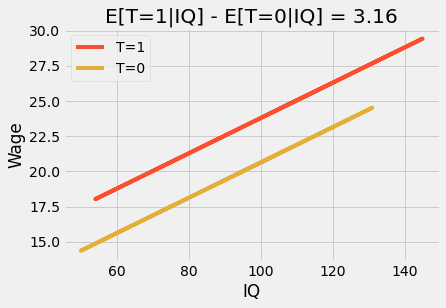

In [18]:
m = smf.ols('hwage ~ T+IQ', data=wage).fit()
plt_df = wage.assign(y_hat = m.fittedvalues)

plt.plot(plt_df.query("T==1")["IQ"], plt_df.query("T==1")["y_hat"], c="C1", label="T=1")
plt.plot(plt_df.query("T==0")["IQ"], plt_df.query("T==0")["y_hat"], c="C2", label="T=0")
plt.title(f"E[T=1|IQ] - E[T=0|IQ] = {round(m.params['T'], 2)}")
plt.ylabel("Wage")
plt.xlabel("IQ")
plt.legend();

In [22]:
m.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,8.0956,2.228,3.634,0.000,3.723,12.468
T,3.1573,0.696,4.535,0.000,1.791,4.524
IQ,0.1253,0.023,5.418,0.000,0.080,0.171


$wage_i = \beta_0 + \beta_1T_i + \beta_2IQ_i * T_i +e_i$

여기서 $\beta_i$는 평균의 조건부 차이이며, 상수 값이다. 위의 경우에는 3.16이다. 

교호작용(interaction)항을 추가하여 이 모델을 더 유연하게 만들 수 있다.

$wage_i = \beta_0 + \beta_1T_i + \beta_2IQ_i + \beta_3IQ_i*T_i + e_i$

각 매개변수가 가지는 의미를 살펴보자.

$\beta_0$ : 처치가 0(12학년을 졸업하지 않은 사람)이고 IQ가 0 일 때 예상되는 임금이다. IQ가 0인 경우는 없을 것으로 이 변수는 그다지 의미 없다.

$\beta_1$ : IQ가 0일 때 12학년을 마치면 예상되는 임금 인상폭이다. 이 역시 IQ가 0인 경우는 없을 것이므로 특별히 의미 없다.

$\beta_2$ : ***IQ가 처치받지 않은 사람들의 임금을 얼마나 증가시킬지*** 알려주는 변수. IQ 1점 당, 12학년을 마치지 못한 사람은 시간당 해당 변수의 값만큼 더 얻을 것으로 기대한다는 것을 의미한다. 위의 경우에서는 0.12, 12센트

$\beta_3$ : 12학년을 졸업할 때 IQ가 얼마나 증가하는지 알려준다. 위의 경우, 이 매개변수는 0.023이다. 즉, IQ점수가 추가될 때마다 12학년을 졸업하면 2센트가 추가된다. 

교호작용(interaction)항을 사용하면 처치 효과가 변수 수준별로 변경될 수 있다.

결과는 예측 선을 plotting하면 더 이상 평행하지 않고 12학년을 졸업한 사람들(T=1)이 IQ에서 더 높은 기울기를 가지며, 낮은 IQ보다 높은 IQ일 때 졸업하면 더 많은 이점을 얻는다는 것을 알 수 있다.

이것은 때때로 효과 수정 또는 이질적인 처치효과로 언급된다.


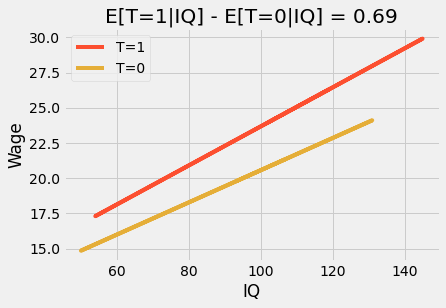

In [23]:
m = smf.ols('hwage ~ T*IQ', data=wage).fit()
plt_df = wage.assign(y_hat = m.fittedvalues)

plt.plot(plt_df.query("T==1")["IQ"], plt_df.query("T==1")["y_hat"], c="C1", label="T=1")
plt.plot(plt_df.query("T==0")["IQ"], plt_df.query("T==0")["y_hat"], c="C2", label="T=0")
plt.title(f"E[T=1|IQ] - E[T=0|IQ] = {round(m.params['T'], 2)}")
plt.ylabel("Wage")
plt.xlabel("IQ")
plt.legend();

마지막으로 모델의 모든 변수가 더미인 경우를 살펴보자.

그렇게 하기 위해 IQ를 4개의 범주로 분리하고 교육 기간을 범주형 변수로 취급한다.

In [24]:
wage_ed_bins = (wage
                .assign(IQ_bins = lambda d: pd.qcut(d["IQ"], q=4, labels=range(4)))
                [["hwage", "educ", "IQ_bins"]])

wage_ed_bins.head()

,hwage,educ,IQ_bins
0,19.225,12,1
1,16.160,18,3
2,20.625,14,2
3,16.250,12,1
4,14.050,11,0


교육 기간을 하나의 범주로 취급하면서 , 우리는 더 이상 교육의 효과를 단일 매개 변수로 제한하지 않는다.

대신, 각 교육연도가 고유한 영향을 미치도록 허용한다.

그렇게 함으로, 교육의 효과가 더 이상 매개변수가 아니기 때문에 유연성을 얻을 수 있다. 

아래 모델은 단순히 각 교육 연도별 평균 임금을 계산한다.

In [25]:
model_dummy = smf.ols('hwage ~ C(educ)', data=wage).fit()
model_dummy.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,18.5600,3.011,6.164,0.000,12.651,24.469
C(educ)[T.10],-0.7874,3.414,-0.231,0.818,-7.488,5.913
C(educ)[T.11],0.1084,3.343,0.032,0.974,-6.452,6.669
C(educ)[T.12],1.7479,3.049,0.573,0.567,-4.236,7.732
C(educ)[T.13],4.3290,3.183,1.360,0.174,-1.918,10.576
C(educ)[T.14],4.0888,3.200,1.278,0.202,-2.192,10.370
C(educ)[T.15],6.3013,3.329,1.893,0.059,-0.231,12.834
C(educ)[T.16],7.2225,3.110,2.323,0.020,1.120,13.325
C(educ)[T.17],9.5905,3.366,2.849,0.004,2.984,16.197
C(educ)[T.18],7.3681,3.264,2.257,0.024,0.962,13.775


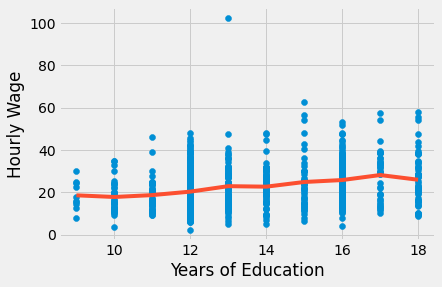

In [26]:
plt.scatter(wage["educ"], wage["hwage"])
plt.plot(wage["educ"].sort_values(), model_dummy.predict(wage["educ"].sort_values()), c="C1")
plt.xlabel("Years of Education")
plt.ylabel("Hourly Wage");

교육이 임금에 어떻게 영향을 미치는지에 대한 함수 형태에 대한 가정을 제거하는 방법에 주목하자.

본질적으로, 이 모델은 완전히 비모수적이다. 이 모델이 하는 일은 교육의 각 연도에 대한 표본 평균 임금을 계산하는 것 뿐이다. 
이것은 적합선이 특정 형태를 갖지 않다는 것을 위의 플롯에서 볼 수 있다.

대신, 각 교육 연도에 대한 표본 평균의 보간이다.

예를 들어, 17년간의 교육 기간 매개변수를 재구성해도 알 수 있다.

이 모델의 경우 9.5905 이다. 아래에서 기준 교육연도(9년)와 17년 개인 간의 차이가 어떻게 되는지 알 수 있다.

$\beta_17 = E[Y|T=17] - E[Y|T = 9]$

절충점은 우리가 그러한 유연성을 허용할 때 통계적 의미를 잃는다는 것이다.

몇년동안 p-values가 얼마나 큰지 알아보자.

In [27]:
t1 = wage.query("educ==17")["hwage"]
t0 = wage.query("educ==9")["hwage"]
print("E[Y|T=9]:", t0.mean())
print("E[Y|T=17]-E[Y|T=9]:", t1.mean() - t0.mean())

E[Y|T=9]: 18.56
E[Y|T=17]-E[Y|T=9]: 9.59047236235352


모델에 더 많은 더미 공변량을 포함하면 교육에 대한 매개 변수는 각 더미 그룹에 대한 효과의 가중 평균이 된다.

$
E\{ \ (E[Y_i|T=1, Group_i] - E[Y_i|T=0, Group_i])w(Group_i) \}
$

$w(Group_i)$는 정확히는 아니지만 $Var(T_i|Group_i)$ 그룹의 처치 분산에 비례한다. 

그룹 가중치가 표본 크기인 전체 비모수 추정기를 사용하지 않는 이유는 무엇일까? 

이것은 실제로 유효한 추정량이지만 회귀가 하는 일은 아니다. 

회귀 분석에서는 처치 분산을 사용함으로써 처치가 많이 달라지는 그룹에 더 많은 가중치를 부여한다. 

이것은 직관적으로 이해가 된다. 

만약 처치가 거의 일정했다면(예를 들어 1명이 처치되고 나모지 모두 처리되지 않음), 표본 크기는 중요하지 않다. 그것은 처치 효과에 대한 많은 정보를 제공하지 않는다.

In [28]:
model_dummy_2 = smf.ols('hwage ~ C(educ) + C(IQ_bins)', data=wage_ed_bins).fit()
model_dummy_2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,18.4178,2.991,6.158,0.000,12.548,24.288
C(educ)[T.10],-1.2149,3.392,-0.358,0.720,-7.872,5.442
C(educ)[T.11],-0.4687,3.332,-0.141,0.888,-7.008,6.070
C(educ)[T.12],0.3400,3.059,0.111,0.912,-5.664,6.344
C(educ)[T.13],2.4103,3.206,0.752,0.452,-3.882,8.702
C(educ)[T.14],1.8040,3.238,0.557,0.578,-4.551,8.159
C(educ)[T.15],3.8599,3.369,1.146,0.252,-2.752,10.472
C(educ)[T.16],4.4060,3.171,1.390,0.165,-1.817,10.629
C(educ)[T.17],6.7470,3.422,1.971,0.049,0.030,13.464
C(educ)[T.18],4.3463,3.332,1.304,0.192,-2.194,10.886
